![Data_Layer](img\ML.png)

#  Machine Learning Layer

### Objectives:
- Forecast future closing prices
- Use machine learning models to predict trends
- Visualize predicted vs actual data


This project analyzes and predicts **Tata Consultancy Services (TCS)** stock price using multiple machine learning and deep learning models. We compare model performance using metrics, visualizations, and 30-day forecasting.

---

## Models Used

| Model               | Type             | Purpose                      | Features Used |
|--------------------|------------------|-------------------------------|---------------|
| **Linear Regression** | Classical ML     | Baseline trend fitting         | OHLCV + MACD, RSI |
| **Random Forest**     | Ensemble ML      | Captures non-linearity         | OHLCV + MACD, RSI |
| **XGBoost**           | Gradient Boosted | Boosted regression with depth  | OHLCV + MACD, RSI |
| **LSTM**              | Deep Learning    | Sequential pattern learning    | Timesteps of OHLCV + MACD, RSI |
| **Facebook Prophet**  | Time Series Tool | Long-term forecasting          | Only 'Close' price and time |

---

## Visual Comparisons

### All Model Predictions vs Actual (Test Set)

- **Actual Price** — black line
- **LSTM** — cyan
- **Random Forest** — green dashed
- **XGBoost** — orange dashed
- **Linear Regression** — blue dashed

---

### Prophet 30-Day Forecast

- Forecast with 95% confidence interval
- Smooth seasonality + trend captured

---

## Evaluation Metrics

### RMSE (Root Mean Squared Error)

| Model               | RMSE         |
|--------------------|--------------|
| **Linear Regression** | `14.71`      |
| **Random Forest**     | `990.85`     |
| **XGBoost**           | `1067.58`    |
| **LSTM**              | `246.29`     |

### R² Score (Coefficient of Determination)

| Model               | R² Score     |
|--------------------|--------------|
| **Linear Regression** | `~0.999`     |
| **Random Forest**     | —            |
| **XGBoost**           | `-2.22` (Overfit/underfit) |
| **LSTM**              | `0.827`      |

---

## Observations

- **Linear Regression** performs surprisingly well due to smoothness of the TCS trend.
- **XGBoost** underperformed, likely due to poor hyperparameters or unscaled input.
- **LSTM** successfully tracks momentum but lags in sharp rises.
- **Prophet** provides consistent long-term trends with uncertainty intervals.

---

## Technical Summary

- **LSTM** used `30-day rolling sequences` with dropout layers.
- **Random Forest / XGBoost / Linear** used engineered indicators (`MACD`, `RSI`, `Signal Line`) as features.
- All models trained on `cleaned_TCS_stock_history.csv`.

---
## Import Libraries

In [9]:

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")



# 📄 Load Data
df = pd.read_csv("data/cleaned_TCS_stock_history.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)


## Forecasting with Facebook Prophet

01:34:34 - cmdstanpy - INFO - Chain [1] start processing
01:34:34 - cmdstanpy - INFO - Chain [1] done processing


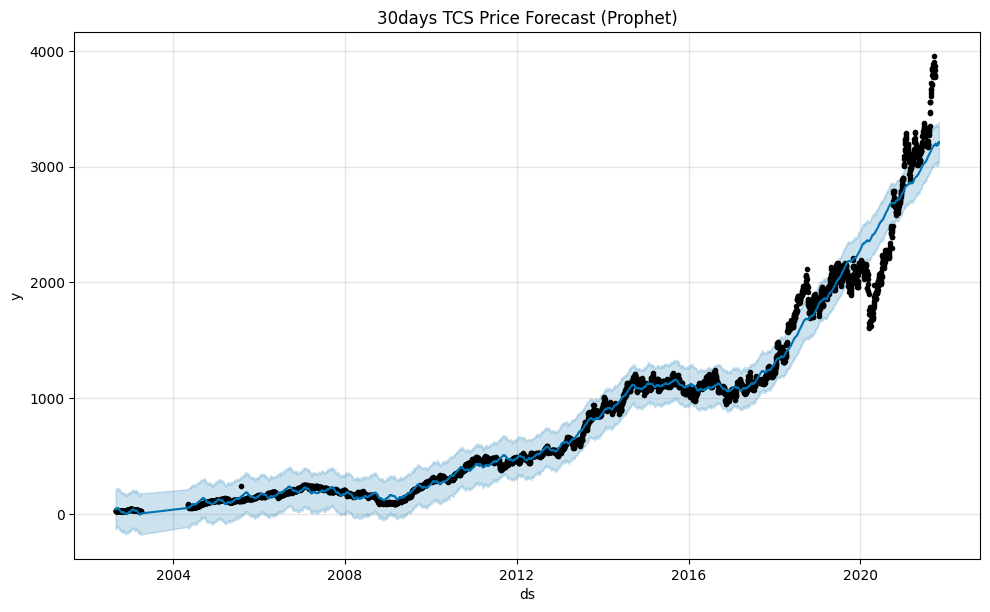

In [2]:


# Prepare data
df_prophet = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'y': 'y'})
df_prophet = df_prophet.rename(columns={'Close': 'y'})

# Fit model
model = Prophet()
model.fit(df_prophet)

# Forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("30days TCS Price Forecast (Prophet)")
plt.show()


## Add Indian holidays (manually or via date list)

01:34:35 - cmdstanpy - INFO - Chain [1] start processing
01:34:36 - cmdstanpy - INFO - Chain [1] done processing


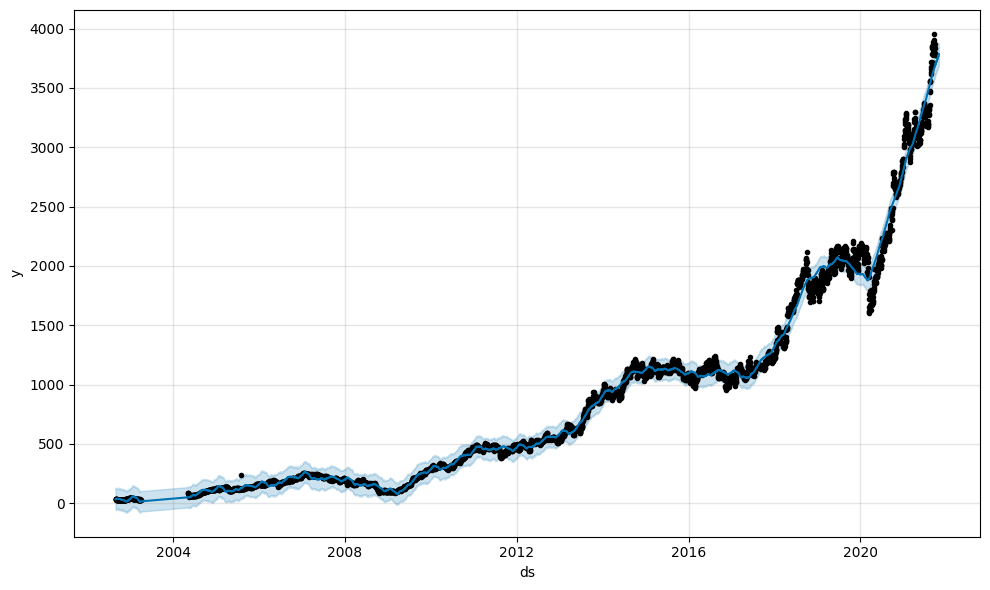

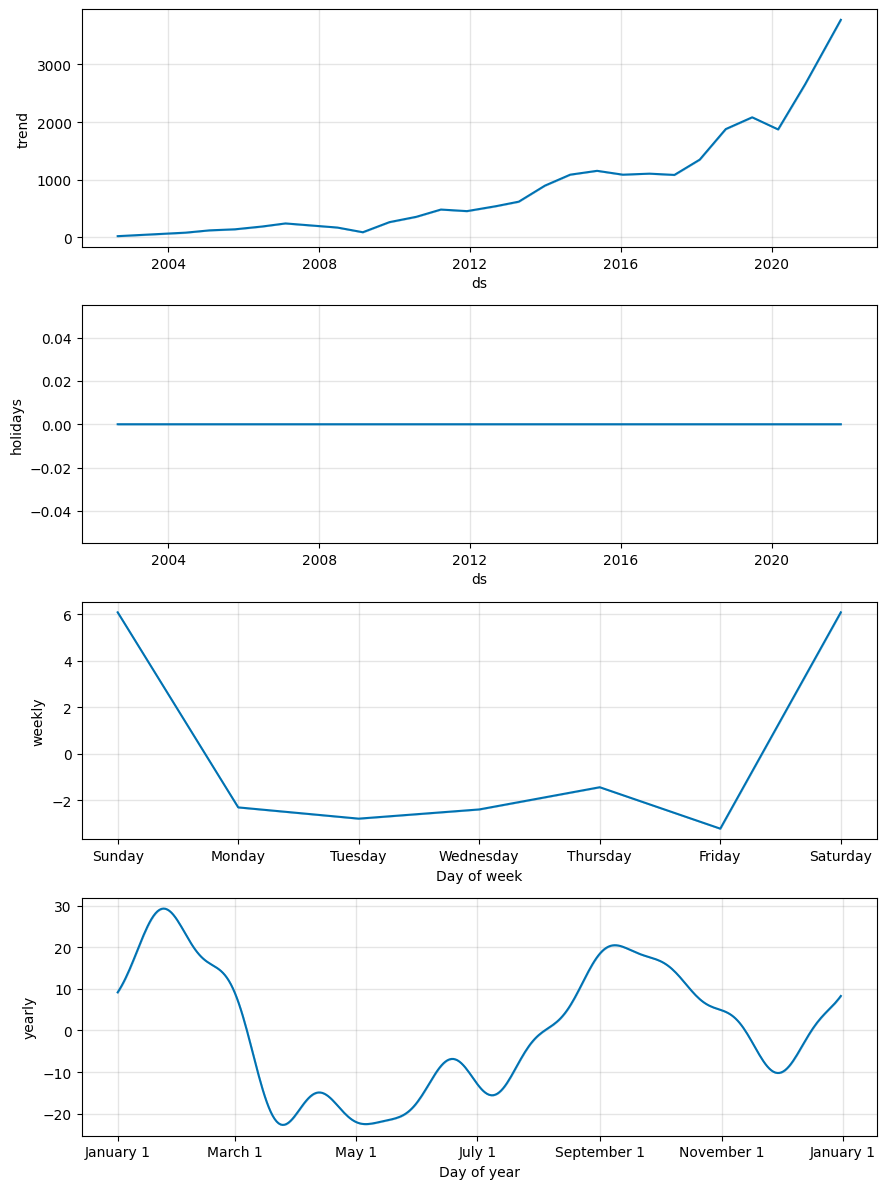

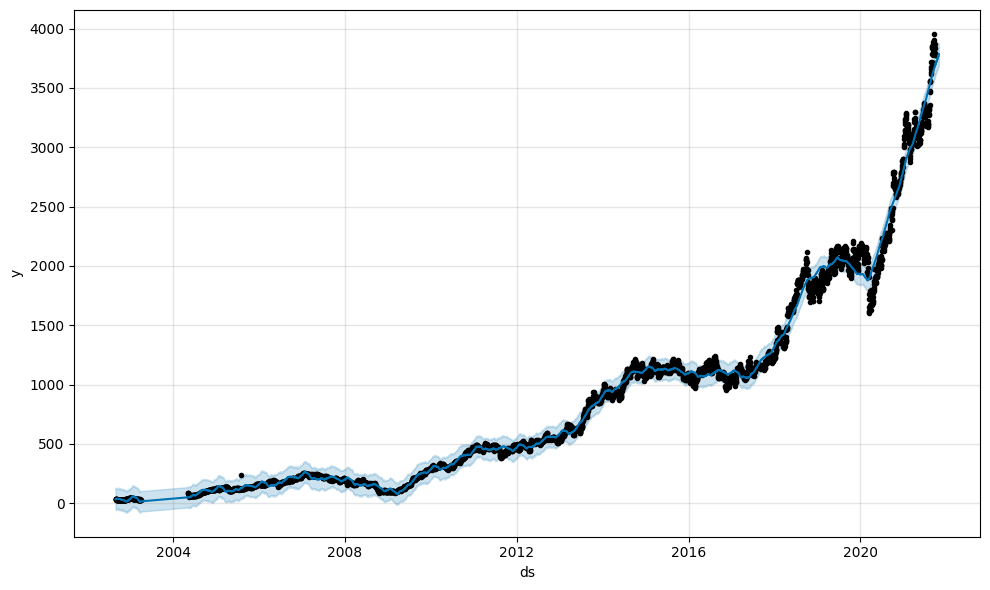

In [3]:

holidays = pd.DataFrame({
    'holiday': 'diwali',
    'ds': pd.to_datetime(['2022-10-24', '2023-11-12']),
    'lower_window': 0,
    'upper_window': 1
})

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_range=0.95,
    changepoint_prior_scale=0.5,
    holidays=holidays
)

model.fit(df_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

model.plot(forecast)
model.plot_components(forecast)

# Save model components
model.plot(forecast).figure.savefig("models/prophet_forecast_plot.png")
forecast.to_csv("models/prophet_forecast_output.csv", index=False)

# To save the Prophet model (experimental workaround):
import pickle
with open("models/prophet_model.pkl", "wb") as f:
    pickle.dump(model, f)
    
with open("models/prophet_model.pkl", "rb") as f:
    prophet_loaded = pickle.load(f)

## Regression: Predicting Close using indicators

🔹 Linear Regression RMSE: 14.190314375430066
🔹 Random Forest RMSE: 991.8981204083401
🔹 XGBoost RMSE: 1066.1067771031358
🔹 XGBoost R² Score: -2.2141647295156925


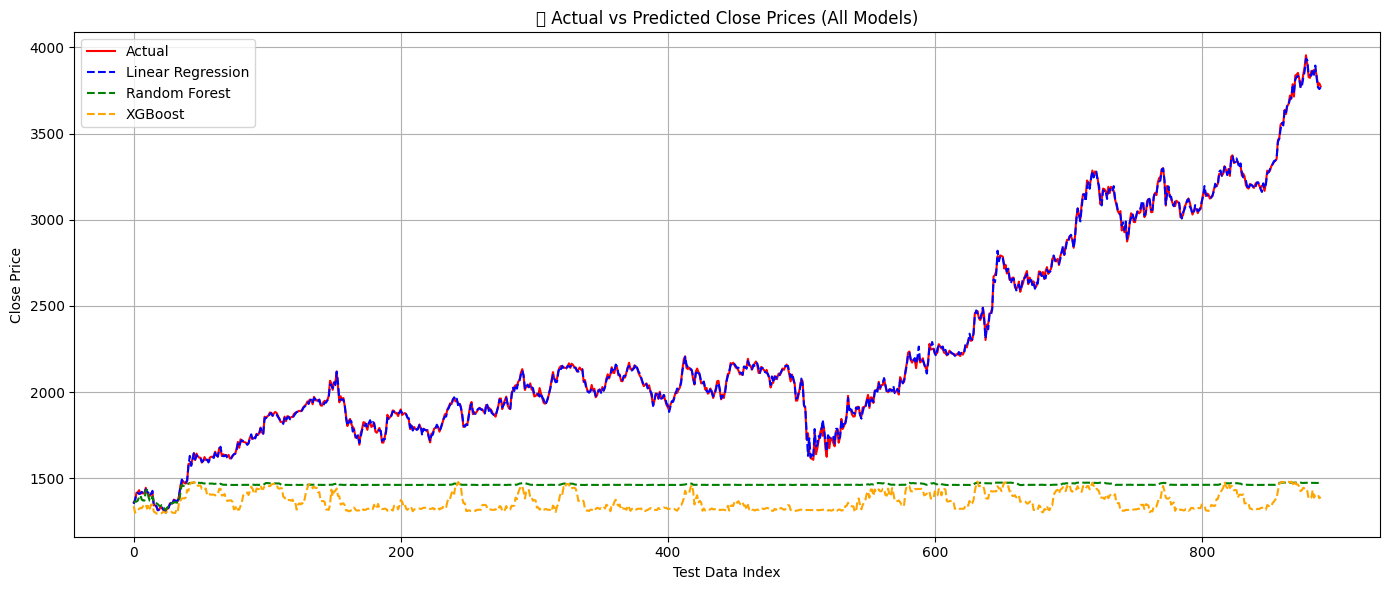

In [4]:
# Define features and target
features = ['Open', 'High', 'Low', 'Volume', 'MACD', 'Signal_Line', 'RSI',
            'Lag_1', 'Lag_2', 'Rolling_Mean_7', 'Rolling_Std_7']
target = 'Close'

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Models
lr = LinearRegression().fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42).fit(X_train, y_train)

# Predictions
lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)
xgb_pred = xgb.predict(X_test)

# Evaluation
print("🔹 Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))
print("🔹 Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))
print("🔹 XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_pred)))
print("🔹 XGBoost R² Score:", r2_score(y_test, xgb_pred))

# Plot all predictions
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual', color='red')
plt.plot(lr_pred, label='Linear Regression', linestyle='--', color='blue')
plt.plot(rf_pred, label='Random Forest', linestyle='--', color='green')
plt.plot(xgb_pred, label='XGBoost', linestyle='--', color='orange')
plt.title("📊 Actual vs Predicted Close Prices (All Models)")
plt.xlabel("Test Data Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save classical models
joblib.dump(lr, "models/linear_regression_model.pkl")
joblib.dump(rf, "models/random_forest_model.pkl")
joblib.dump(xgb, "models/xgboost_model.pkl")

lr_loaded = joblib.load("models/linear_regression_model.pkl")

## Preprocessing for LSTM

In [5]:
# Select features
features = ['Open', 'High', 'Low', 'Volume', 'MACD', 'Signal_Line', 'RSI']
target = 'Close'

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

# Define sequence window
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, :-1])  # all features except target
        y.append(data[i, -1])  # target is the last column
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(scaled_data, window=window_size)

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


## Build and Train LSTM Model

In [6]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dropout(0.3))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0040 - val_loss: 1.0502e-04 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9679e-04 - val_loss: 1.6588e-04 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.7355e-04 - val_loss: 1.7791e-04 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7577e-04 - val_loss: 2.7522e-04 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5638e-04 - val_loss: 2.7303e-04 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1714e-04 - val_loss: 1.0441e-04 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0305e-04 - val_loss: 1.0082e-04 - learning_rate: 2.0000e-04
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8625e-04 - val_loss: 1.9127e-04 - learning_rate: 2.0000e-04
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━

## Evaluate and Plot Predictions and Save Model

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
🔹 LSTM RMSE: 265.88491082763954
🔹 LSTM R² Score: 0.7985735454974185


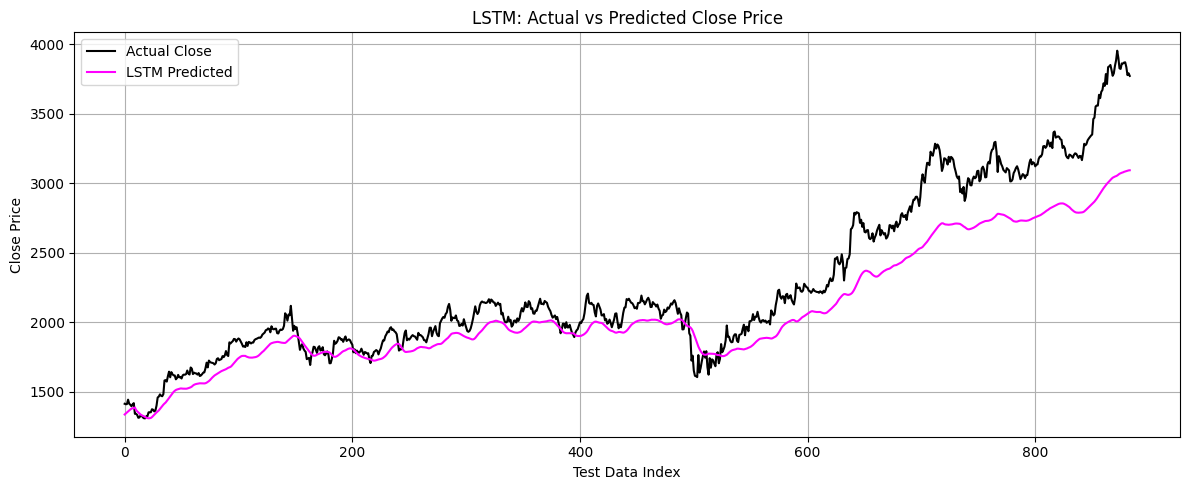

In [7]:
# Predict
y_pred = model.predict(X_test)

# Invert scaling
close_scaler = MinMaxScaler()
close_scaler.fit(df[['Close']])  # fit only on original Close for inverse transform
y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = close_scaler.inverse_transform(y_pred)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print("🔹 LSTM RMSE:", rmse)
print("🔹 LSTM R² Score:", r2)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_rescaled, label='Actual Close', color='black')
plt.plot(y_pred_rescaled, label='LSTM Predicted', color='magenta')
plt.title("LSTM: Actual vs Predicted Close Price")
plt.xlabel("Test Data Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model.save("models/lstm_model.keras")


## Align All Predictions and Plot all Models Comparison

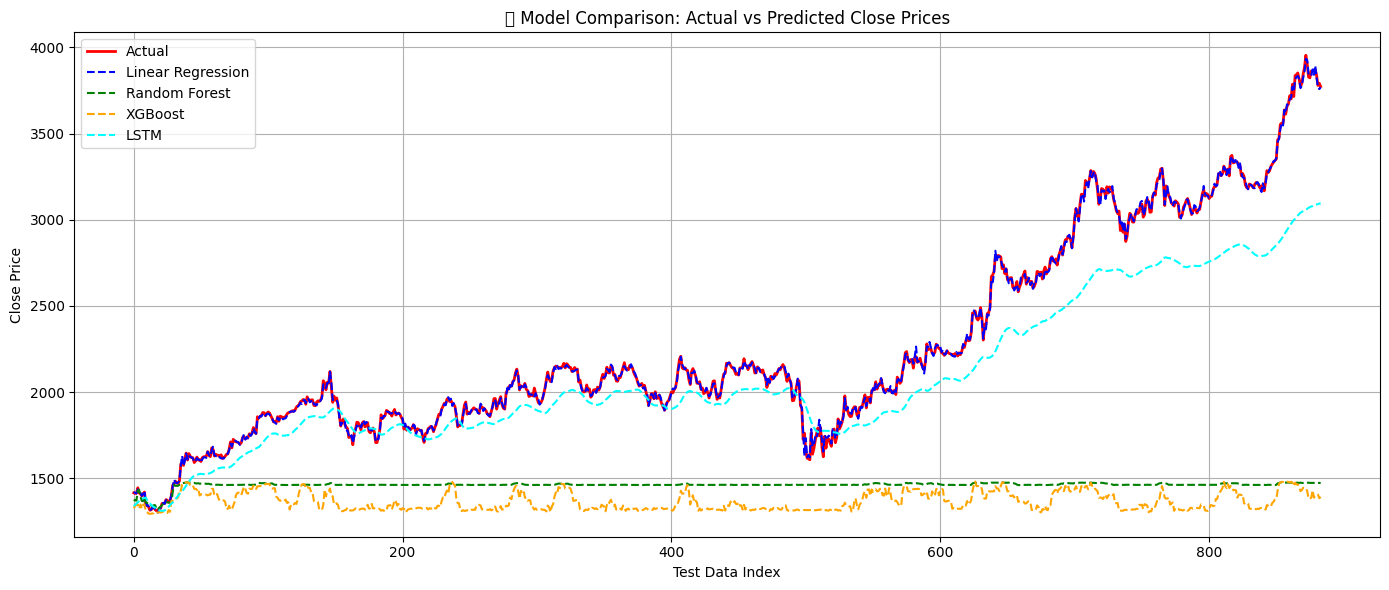

In [8]:
# Ensure all predictions are aligned in length and scale
# Slice other models' predictions to match LSTM's test size
test_len = len(y_test_rescaled)
lr_rescaled = y_test_rescaled[:test_len].copy()  # placeholder for axis match
rf_rescaled = y_test_rescaled[:test_len].copy()
xgb_rescaled = y_test_rescaled[:test_len].copy()

lr_rescaled[:, 0] = lr_pred[-test_len:]
rf_rescaled[:, 0] = rf_pred[-test_len:]
xgb_rescaled[:, 0] = xgb_pred[-test_len:]

plt.figure(figsize=(14, 6))
plt.plot(y_test_rescaled, label='Actual', color='red', linewidth=2)
plt.plot(lr_rescaled, label='Linear Regression', linestyle='--', color='blue')
plt.plot(rf_rescaled, label='Random Forest', linestyle='--', color='green')
plt.plot(xgb_rescaled, label='XGBoost', linestyle='--', color='orange')
plt.plot(y_pred_rescaled, label='LSTM', linestyle='--', color='cyan')

plt.title("📊 Model Comparison: Actual vs Predicted Close Prices")
plt.xlabel("Test Data Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---